# Value investing with ML
### Objective: Evaluate if a stock is relatively undervalued or overvalued using ML, 
### Steps:
1. Get Data: We need data to train our model
2. Prepare Data: Clean, normalize, and get data in a form that we can feed into our model
3. Train Model: Feed in prepared to our Model
4. Evaluate and Fix: Does the Model work? Also, fix any bugs common Machine Learning bugs that may have appeared
5. Develop Algorithm: Backtest ML Model based Algorithm
6. Analyze Performance: Measure performance and risk of our Algorithm

### In-depth Explanation of strategy
Traditionally, <b>Value Investing</b> is buying a company when it looks cheap, and selling it once it seems expensive. To determine the relative value of a company is where Machine Learning comes in. We will run fundamental data through our model, and through averaging of results through ensemble, we will get a model that can estimate the relative "fairness" of the value of a company. When a company is below "fair", it is considered to be "undervalued" and when a company is above, it is considered to be "overvalued", relatively speaking.

### Caveats
Since we cannot buy/sell companies that go bankrupt, there could be survivorship bias in our model.

In [111]:
# STEP 1: get data
import simfin as sf
from simfin.names import *
import pandas as pd

sf.set_data_dir('data') # which folder to store data
sf.set_api_key(api_key='free')

# load data
data1 = sf.load_income(variant='annual', market='us').copy()
data1.reset_index(inplace=True)
data2 = sf.load_cashflow(variant='annual', market='us').copy()
data2.reset_index(inplace=True)
data3 = sf.load_balance(variant='annual', market='us').copy()
data3.reset_index(inplace=True)
hub = sf.StockHub(market='us')
data4 = hub.val_signals().copy()
data4.reset_index(inplace=True)
data5 = hub.val_signals(variant='latest').copy()
data5.reset_index(inplace=True)


Dataset "us-income-annual" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-annual" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-balance-annual" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-shareprices-daily" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-income-ttm" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (0 days old).
- Loading from disk ... Done!
Cache-file 'val_signals-77ca1f39.pickle' on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-shareprices-latest" on disk (0 days old).
- Loading from disk ... Done!
Cache-file 'val_signals-9541e2e6.pickle' on disk (0 days old).
- Loading from disk ... Done!


In [0]:
# STEP 2: clean and prepare data
rows_to_drop = ['SimFinId', 'Currency', 'Fiscal Period', 'Fiscal Year', 
       'Publish Date', 'Shares (Diluted)']
def drop_rows(df):
    return df.drop(rows_to_drop, axis=1)
    

df1 = drop_rows(data1)
df2 = drop_rows(data2)
df3 = drop_rows(data3)
df4 = data4[[TICKER, DATE, MARKET_CAP]]

In [117]:
# join data together
super_df = df1.merge(df2, on=[TICKER, REPORT_DATE], how='inner')
print(super_df.head)
super_df = super_df.merge(df3, on=[TICKER, REPORT_DATE], how='inner')
super_df[REPORT_DATE] = pd.to_datetime(super_df[REPORT_DATE]).dt.normalize()
super_df = super_df.merge(df4, left_on=[TICKER, REPORT_DATE], right_on=[TICKER, DATE], how='inner')

<bound method NDFrame.head of       Ticker  ... Net Change in Cash
0          A  ...         -421000000
1          A  ...         1074000000
2          A  ...          170000000
3          A  ...          878000000
4          A  ...        -1174000000
...      ...  ...                ...
15245    low  ...         -150000000
15246    low  ...           75000000
15247    low  ...          -61000000
15248    low  ...          153000000
15249    low  ...           30000000

[15250 rows x 40 columns]>


In [0]:
super_df.columns

Index(['Ticker', 'Report Date', 'Shares (Basic)_x', 'Revenue',
       'Cost of Revenue', 'Gross Profit', 'Operating Expenses',
       'Selling, General & Administrative', 'Research & Development',
       'Depreciation & Amortization_x', 'Operating Income (Loss)',
       'Non-Operating Income (Loss)', 'Interest Expense, Net',
       'Pretax Income (Loss), Adj.', 'Abnormal Gains (Losses)',
       'Pretax Income (Loss)', 'Income Tax (Expense) Benefit, Net',
       'Income (Loss) from Continuing Operations',
       'Net Extraordinary Gains (Losses)', 'Net Income', 'Net Income (Common)',
       'Shares (Basic)_y', 'Net Income/Starting Line',
       'Depreciation & Amortization_y', 'Non-Cash Items',
       'Change in Working Capital', 'Change in Accounts Receivable',
       'Change in Inventories', 'Change in Accounts Payable',
       'Change in Other', 'Net Cash from Operating Activities',
       'Change in Fixed Assets & Intangibles',
       'Net Change in Long Term Investment',
       'Ne

In [0]:
# remove unnecessary/duplicate columns
sfc_df = super_df.drop([REPORT_DATE, 'Shares (Basic)_x'], axis=1)
sfc_df.drop(super_df.filter(regex='_y$').columns.tolist(), axis=1,  inplace=True)

# using dummies prevents our algorithm from finding a numerical relationship in 
# a categorical feature
dummy_years = pd.get_dummies(sfc_df[DATE])
sfc_df = pd.concat([sfc_df, dummy_years], axis=1)
backtest_data = sfc_df[sfc_df[DATE].dt.year == 2018]
ml_data = sfc_df[sfc_df[DATE].dt.year != 2018]
del ml_data[DATE], ml_data[TICKER], backtest_data[DATE]
ml_data = ml_data.fillna(value=0)

In [122]:
# STEP 3: train model

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
model = RandomForestRegressor(random_state=42)

y = ml_data[MARKET_CAP].values
X = ml_data.drop(MARKET_CAP, axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
print(metrics.r2_score(y_test, predicted))
model.fit(X, y)

-212.62115216972546


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [0]:
from trade_stat_logger.logger import SimpleLogger

# STEP 5: develop algorithm

# format data that we will run through backtester
latest_df = data5[[TICKER, DATE, MARKET_CAP]]
# filter to get only companies that are alive in May 2020
latest_df = latest_df[(latest_df[DATE].dt.year == 2020) & (latest_df[DATE].dt.month == 5)]
latest_df.set_index(TICKER, inplace=True)

logger = SimpleLogger()

# predict market cap
def predict(data):
    return model.predict([data])[0]

for index in backtest_data.index:
    try:
        row = backtest_data.loc[index].copy().fillna(value=0)
        ticker = row[TICKER]
        mktcap = row[MARKET_CAP]
        mktcap_curr = latest_prices.loc[ticker][MARKET_CAP] / 1e6
    except KeyError:
        # means a ticker no longer exists or didn't exist before
        break

    position_size = mktcap / 1e6
    position_size_curr = mktcap_curr / 1e6
    del row[TICKER], row[MARKET_CAP]
    predicted = predict(row)
    #print(position_size)
    if position_size > 0.0 and position_size_curr > 0:
        if predicted * .9 < mktcap:
            # case overvalued
            logger.log(security=ticker, shares=-1, share_price=position_size)
            logger.log(security=ticker, shares=1, share_price=position_size_curr)
        elif predicted * 1.1 > mktcap:
            # case undervalued
            logger.log(security=ticker, shares=1, share_price=position_size)
            logger.log(security=ticker, shares=-1, share_price=position_size_curr)
    

/usr/local/lib/python3.6/dist-packages/trade_stat_logger/logger.py:115: UserWarning: For most accurate performance results, please clear all holdings, which you can do with clear_all_positions()
  warn('For most accurate performance results, please clear all holdings, which you can do with clear_all_positions()')


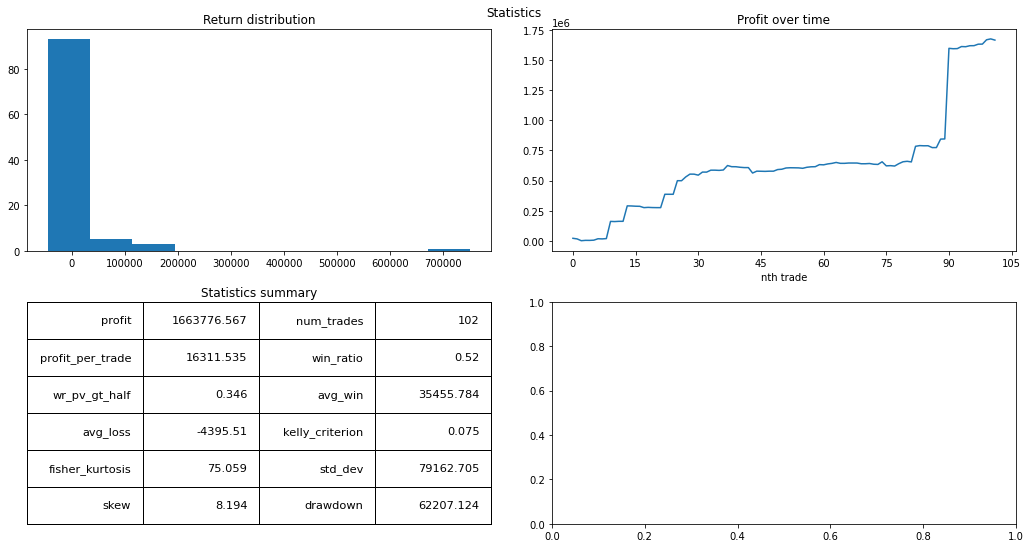

In [124]:
# STEP 6: Analyze Algorithm Performance
logger.graph_statistics()